## Segment Anything Model (SAM) initialiseren
In dit blok importeren we de benodigde bibliotheken en initialiseren we het SAM-model dat verantwoordelijk is voor de segmentatie.

We kiezen voor het vit_h model (Vision Transformer - Huge), de krachtigste versie van SAM.

We laden de bijbehorende modelgewichten via het bestand sam_vit_h_4b8939.pth.

Tot slot maken we een SamPredictor object aan, waarmee we later segmentatie kunnen uitvoeren op afbeeldingen.

In [1]:
# === Imports en SAM initialiseren ===
import numpy as np
import cv2
import matplotlib.pyplot as plt
from segment_anything import sam_model_registry, SamPredictor
from segment_anything import SamAutomaticMaskGenerator
from PIL import Image

sam_checkpoint = "models/sam_vit_h_4b8939.pth" # het .pth bestand met de gewichten van het SAM-model
model_type = "vit_h" # het type ViT (Vision Transformer) architectuur dat SAM gebruikt
sam = sam_model_registry[model_type](checkpoint=sam_checkpoint)
predictor = SamPredictor(sam)

## Afbeelding voorbereiden en klikpunten genereren

In dit blok wordt de invoerafbeelding geladen en omgezet naar het juiste kleurformaat (RGB), zoals vereist door het SAM-model. Vervolgens definiëren we twee sets klikpunten:

**Dakpunten**: Een paar punten hoog in de afbeelding, bedoeld om alleen het dak te detecteren.

**Gebouwpunten**: Een paar punten rond het midden van het gebouw, bedoeld om het volledige huis te segmenteren.

In [2]:
# === Afbeelding laden en converteren ===
afbeelding = "half_vrijstaand_type_e (4)_contours.png"
image = cv2.imread(f"Resultaten_met_Contouren/{afbeelding}")
image_rgb = cv2.cvtColor(image, cv2.COLOR_BGR2RGB) # Zet de afbeelding om van BGR naar RGB omdat dat handiger is voor SAM (OpenCV laadt standaard in het BGR-kleurformaat wat is niet compatibel met SAM)
predictor.set_image(image_rgb)

# image is nu een numpy-array van vorm (hoogte, breedte, 3 (met pixelwaarden tussen 0–255 [120, 0, 255]))
h, w, _ = image.shape
center_x, center_y = w // 2, h // 2

# === Meerdere punten genereren hoog in de beeld voor het dakdetectie ===
dak_punten = np.array([[center_x, center_y - 250], [center_x - 100, center_y - 250], [center_x + 100, center_y - 250],
                       [center_x, center_y - 200], [center_x - 100, center_y - 200], [center_x + 100, center_y - 200],
                       [center_x, center_y - 150], [center_x - 100, center_y - 150], [center_x + 100, center_y - 150]])
dak_labels = np.ones(len(dak_punten))

# === Meerdere punten genereren rond het midden voor het gebouwdetectie ===
offset_x = 60 #  hoeveel pixels rond het midden we extra punten willen plaatsen
offset_y = 120 #  hoeveel pixels rond het midden we extra punten willen plaatsen

huis_punten = np.array([[center_x + dx, center_y + dy] for dx in [-offset_x, 0, offset_x] for dy in [-offset_y, 0, offset_y]])
huis_labels = np.ones(len(huis_punten))

## Segmentatie uitvoeren en beste masker selecteren
In deze block geven wij de eerder gedefinieerde punten aan het SAM-model (predictor) door om de segmentatie tweemaal uit te voeren. Het model retourneert meerdere maskers. Elk masker is een mogelijke interpretatie van wat een object kan zijn op basis van de inputpunten. Wij kiesen vervolgens het beste masker op basis van de hoogste confidence score (scores).

De score wordt waarschijnlijk bepaald door een paar factoren zoals

**Factor**                                      Betekenis

**Maskerkwaliteit**                             Hoe scherp/duidelijk is de grens van het masker?

**Overeenkomst met inputprompt (klikpunten)**   Ligt het masker goed om de opgegeven punt(en)?

**Afsluiting (compleetheid)**                   Is het een gesloten contour, zonder gaten?

**Consistentie met features uit de encoder**    Komt het masker overeen met interne kenmerken (textures, randen, vormen)?

In [3]:
# === Segmentatie uitvoeren ===
# Dak segmenteren
dak_masks, dak_scores, _ = predictor.predict(
    point_coords=dak_punten,
    point_labels=dak_labels,
    multimask_output=True
)
dak_mask = dak_masks[np.argmax(dak_scores)] # np.argmax(dak_scores): bepaalt de index van het masker met de hoogste score (dus het meest betrouwbare masker).

# Huis segmenteren
huis_masks, huis_scores, _ = predictor.predict(
    point_coords=huis_punten,
    point_labels=huis_labels,
    multimask_output=True
)
huis_mask = huis_masks[np.argmax(huis_scores)] # np.argmax(huis_scores): bepaalt de index van het masker met de hoogste score (dus het meest betrouwbare masker).

## Visualisatie van het dakmasker

We visualiseren het segmentatiemasker dat is gegenereerd op basis van de dakpunten. De blauwe cirkels zijn de ingevoerde klikpunten.

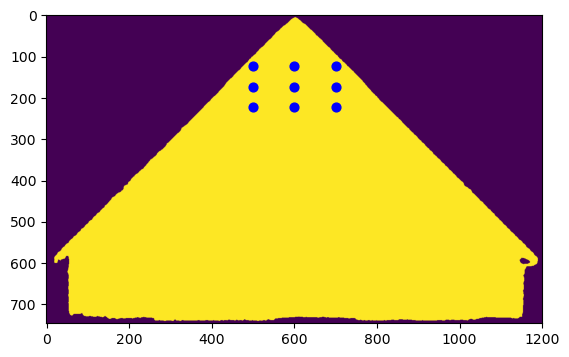

In [4]:
plt.imshow(dak_mask)
plt.scatter(dak_punten[:, 0], dak_punten[:, 1], color="blue", s=40, marker="o", label="Invoerpunt")

## Visualisatie van het volledige gebouwmasker

Hier tonen we het segmentatiemasker van het hele gebouw, verkregen via klikpunten rond het midden van het huis.

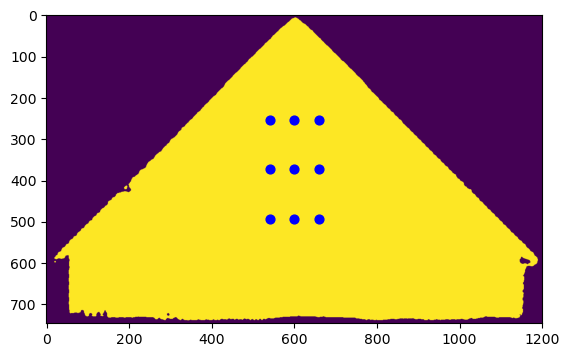

In [5]:
plt.imshow(huis_mask)
plt.scatter(huis_punten[:, 0], huis_punten[:, 1], color="blue", s=40, marker="o", label="Invoerpunt")

## Gebouw uitsnijden en opslaan
We willen de originele afbeelding omzetten naar een versie waarin alleen het segment (het huis) zichtbaar is en de rest transparant wordt. Dit is handig voor:

verdere analyse (zoals ramen/deuren zoeken binnen het gebouw),

overlay op de originele afbeelding,

eenvoudiger gebruik van segmentatie in latere stappen.

In [6]:
# === RGBA afbeelding maken met alleen het gebouw ===
huis_rgba = np.zeros((image_rgb.shape[0], image_rgb.shape[1], 4), dtype=np.uint8) # We maken een nieuwe lege afbeelding van dezelfde hoogte & breedte als de originele (image_rgb).
huis_rgba[:, :, :3] = image_rgb # We kopiëren de RGB-waarden van de originele afbeelding.
huis_rgba[:, :, 3] = (huis_mask * 255).astype(np.uint8) # beste_mask is een boolean-array (True/False): waar het huis is gedetecteerd.

# === Opslaan als PNG met transparantie ===
img_pil = Image.fromarray(huis_rgba)
img_pil.save(f"Data_nest_uitgesneden_zonder_achtergrond/{afbeelding}")

## Segmentatie voorbereiden
In dit blok zetten we de afbeelding (image) om naar het RGB-kleurschema, zoals vereist door het SAM-model. Daarna roepen we SamAutomaticMaskGenerator aan om automatisch alle segmenten (objecten) in de afbeelding te detecteren.

In [7]:
# image naar het RGB-kleurschema zetten
huis_image_rgb = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)

# Segmentatie genereren met SAM
mask_generator = SamAutomaticMaskGenerator(sam)
resultaten = mask_generator.generate(huis_image_rgb)

## Grootste segment bepalen
Hier bepalen we de oppervlakte (in pixels) van elk gesegmenteerd object door het aantal True-waarden in de maskers op te tellen. We nemen het grootste aantal als referentie om later segmenten in "klein", "middelgroot" en "groot" te classificeren.

In [8]:
max_area = max(np.sum(m["segmentation"]) for m in resultaten)

## Masker van alleen het gebouw laden
We laden de eerder opgeslagen afbeelding met een transparante achtergrond. Het alpha-kanaal (vierde kanaal) vertelt ons welke pixels tot het gebouw horen (alpha > 0). Deze info wordt gebruikt om alleen segmenten binnen het huis toe te staan.

In [9]:
huis_rgba = np.array(Image.open(f"Data_nest_uitgesneden_zonder_achtergrond/{afbeelding}"))
alpha_mask = huis_rgba[:, :, 3] > 0   # True = gebouw

## Kleur toepassen op gebouwsegmenten
We doorlopen alle segmenten uit de automatische segmentatie. We combineren elk masker met het gebouwmasker om ervoor te zorgen dat we alleen delen binnen het huis inkleuren. Vervolgens bepalen we de kleur op basis van de grootte van het segment en kleuren de corresponderende pixels in de afbeelding

In [10]:
for m in resultaten:
    mask = m["segmentation"]
    area = np.sum(mask)

    # Segmenten buiten het gebouw negeren
    geldig_mask = mask & alpha_mask
    if np.sum(geldig_mask) < area * 0.5: # Als minder dan 50% van het segment binnen het gebouw ligt, wordt het segment overgeslagen.
        continue                         # (Dit voorkomt dat ruis of delen van de achtergrond toch per ongeluk worden ingekleurd.)


    # Kleur op basis van grootte
    if area < max_area * 0.1:
        kleur = [0, 255, 0]      # klein object → groen
    elif area < max_area * 0.5:
        kleur = [255, 255, 0]    # medium object → geel
    else:
        kleur = [255, 0, 0]      # groot object → rood

    for c in range(3):
        huis_image_rgb[:, :, c][geldig_mask] = kleur[c]

## Dak blauw kleuren op basis van relatieve grootte
We controleren of het dakoppervlak tussen de 10% en 70% van het gebouwoppervlak ligt. Als dat zo is, kleuren we het dak blauw. Zo voorkomen we dat het hele gebouw blauw wordt gekleurd bij incorrecte detectie.

In [11]:
# Bepaal het aantal pixels in het dak en gebouw
dak_area = np.sum(dak_mask)
gebouw_area = np.sum(huis_mask)

# Controleer of het dak qua grootte tussen 10% en 70% van het gebouw is
if gebouw_area > 0:
    verhouding = dak_area / gebouw_area
    if 0.1 <= verhouding <= 0.7:
        blauw = [0, 0, 255]  # RGB-kleurcode voor blauw
        for c in range(3):
            huis_image_rgb[:, :, c][dak_mask] = blauw[c]

## Rechthoekigheid controleren van groene segmenten
We willen alleen écht raam-/deurvormige objecten (rechthoeken) behouden. Groene vlekken die niet voldoen aan de vormverwachting (bijv. te langwerpig of slecht gevuld) worden rood gekleurd zodat ze uit de uiteindelijke analyse verdwijnen.

In [12]:
# Maak een binair masker van alle groene pixels (ramen/deuren)
groen_masker = np.all(huis_image_rgb == [0, 255, 0], axis=2).astype(np.uint8) * 255

# Zoek contouren in het groene masker
contours, _ = cv2.findContours(groen_masker, cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)

for contour in contours:
    area = cv2.contourArea(contour)
    x, y, w, h = cv2.boundingRect(contour)
    rect_area = w * h

    if rect_area == 0:
        continue  # Vermijd delen door nul

    verhouding = area / rect_area

    # Als het groene object niet rechthoekig genoeg is (zoals gras of bomen), verwijder het
    if verhouding < 0.6:
        cv2.drawContours(huis_image_rgb, [contour], -1, (255, 0, 0), thickness=cv2.FILLED)

## Visualisatie
Tot slot tonen we het resultaat: de originele afbeelding van het huis waarin de gesegmenteerde onderdelen zijn ingekleurd op basis van hun grootte (zonder de achtergrond te kleuren). Hiermee krijgen we visueel inzicht in de structuur van het gebouw.

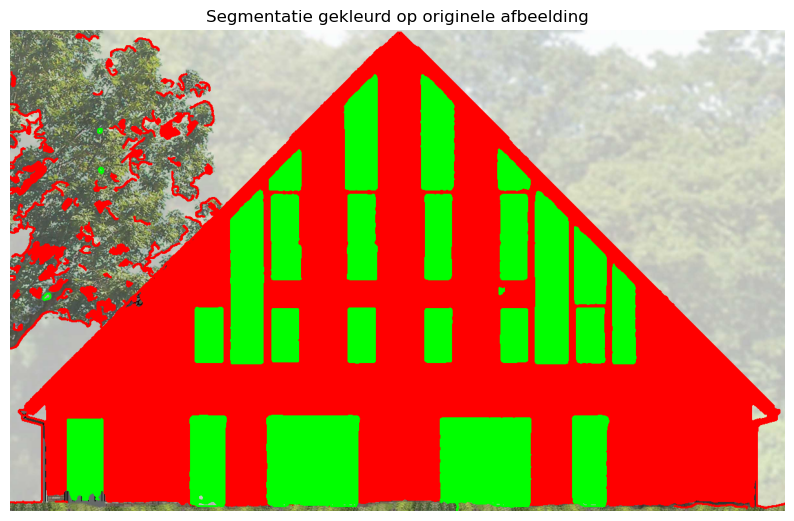

In [13]:
plt.figure(figsize=(10, 10))
plt.imshow(huis_image_rgb)
plt.title("Segmentatie gekleurd op originele afbeelding")
plt.axis("off")
plt.show()

In [14]:
Image.fromarray(huis_image_rgb).save(f"Data_nest_uitgesneden_output/{afbeelding}")

## Ground-truth masker laden vanuit YOLO-labelbestand
We laden de ground-truth segmentatie (bijv. van ramen/deuren) uit een `.txt`-bestand in YOLOv8-formaat. Deze informatie gebruiken we straks om een IoU-score te berekenen.

In [15]:
# Specificeer het pad naar het bijbehorende YOLOv8-ground-truth bestand
txt_path = "Test_data/half_vrijstaand_type_e-4-_png.rf.43e530b98b2c051a8aa4a235fddc4957.txt"
img_shape = image.shape
class_id = 3  # ramen/deuren

# Maak leeg binair masker
h, w = img_shape[:2]
ground_truth_mask = np.zeros((h, w), dtype=np.uint8)

# Lees polygonen uit YOLO .txt en vul ze in het masker
with open(txt_path, "r") as f:
    for line in f:
        parts = line.strip().split()
        if int(parts[0]) != class_id:
            continue

        coords = np.array([float(x) for x in parts[1:]]).reshape(-1, 2)
        coords[:, 0] *= w  # schaal X
        coords[:, 1] *= h  # schaal Y
        polygon = np.round(coords).astype(np.int32)
        cv2.fillPoly(ground_truth_mask, [polygon], 255)

# Zet om naar boolean masker voor gebruik met IoU
ground_truth_mask = ground_truth_mask > 0

## Grondwaarheidsmasker laden
Hier laden we een RGB-afbeelding die handmatig is gelabeld als grondwaarheid (bijv. via Roboflow). We gebruiken dit masker later voor evaluatie.

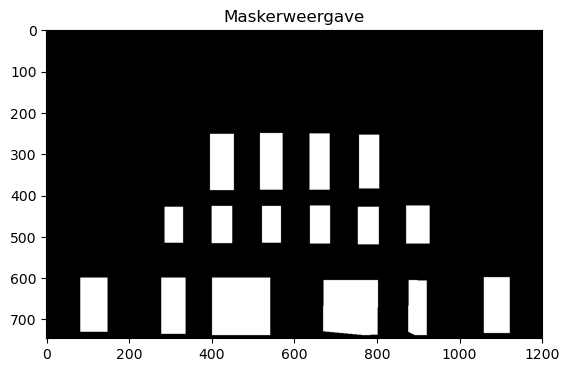

In [16]:
plt.imshow(ground_truth_mask, cmap='gray')
plt.title("Maskerweergave")
plt.show()

## Evaluatiemetrics: IoU, Precision, Recall en mAP
Om de prestaties van segmentatiemodellen zoals SAM of YOLOv8 te evalueren, worden standaard enkele belangrijke statistieken gebruikt:

### IoU – Intersection over Union
De **overlap tussen het voorspelde en het echte gebied**. Hoe groter de overlap, hoe beter het model.
- Formule: `IoU = intersectie / unie`
- Wordt vaak gebruikt om te bepalen of een voorspelling "goed genoeg" is.

### Precision – Nauwkeurigheid
Geeft aan hoeveel van de voorspellingen correct zijn.
- Formule: `Precision = TP / (TP + FP)`
- Hoog als er weinig fout-positieve detecties zijn.

### Recall – Herkenningsgraad
Geeft aan hoeveel van de echte objecten daadwerkelijk gevonden zijn.
- Formule: `Recall = TP / (TP + FN)`
- Hoog als het model weinig objecten mist.

### mAP\@0.5 – Mean Average Precision bij IoU ≥ 0.5
De gemiddelde precisie over alle klassen, waarbij voorspellingen als correct tellen als `IoU ≥ 0.5`.

### mAP\@0.5:0.95 – Striktere evaluatie
De gemiddelde van mAP bij `IoU thresholds van 0.5 tot 0.95` in stappen van 0.05.
- Deze waarde wordt vaak als de **belangrijkste indicator** gebruikt in professionele benchmarks (zoals COCO).

In de onderstaande stap voeren we een **IoU-berekening** uit tussen het grondwaarheidsmasker (YOLO-labels) en de segmentatieoutput van SAM voor de objectklasse *ramen/deuren*.

In [17]:
# Genereer een masker van alle groene SAM-segmenten
sam_groen_mask = np.all(huis_image_rgb == [0, 255, 0], axis=-1)

# TP (True Positives): overlap tussen SAM en YOLO
tp = np.logical_and(sam_groen_mask, ground_truth_mask).sum()

# FP (False Positives): SAM voorspelt iets wat niet in YOLO zit
fp = np.logical_and(sam_groen_mask, ~ground_truth_mask).sum()

# FN (False Negatives): YOLO heeft objecten die SAM mist
fn = np.logical_and(~sam_groen_mask, ground_truth_mask).sum()

# Precision: Hoeveel van de groene SAM-segmenten zijn echt goed
precision = tp / (tp + fp)

# Recall: Hoeveel van de echte ramen/deuren heeft SAM gevonden
recall = tp / (tp + fn)

# F1-score kan ook: Simpele gemiddeld tussen precision en recall als benadering
map_05 = (precision + recall) / 2

# IoU: verhouding tussen de overlap en de totale oppervlakte
iou = tp / (tp + fp + fn)

# Print de evaluatiestatistieken
print(f"Evaluatie SAM-segmentatie t.o.v. YOLO-ground-truth:")
print(f"Precision: {precision:.4f}")
print(f"Recall:    {recall:.4f}")
print(f"mAP@0.5:   {map_05:.4f}")
print(f"IoU:       {iou:.4f}")

Evaluatie SAM-segmentatie t.o.v. YOLO-ground-truth:
Precision: 0.6178
Recall:    0.8257
mAP@0.5:   0.7218
IoU:       0.5465
